# Abstracts LDA

* Load the abstracts from the review articles identified in 05_benchmark_articles notebook.
* Create a corpus with the abstracts
* Tokenize
* Apply single LDA
* Apply ensemble LDA

## Conclusion
Doing an LDA on the abstracts just yields that these are systematic literature review papers. It does not give ainformation about what these reviews are about.

In [6]:
import pandas as pd
import os
import PyPDF2
from collections import defaultdict
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import EnsembleLda
import numpy as np

## Load the abstracts 
From the review articles on machine learning identified in 05_benchmark_articles notebook. Keep only the abstracts.

In [7]:
%%time

# load metadata extracted data in notebook 00_load_metadata
arxiv_ml_reviews = pd.read_csv('data/arxiv_ml_reviews.csv.zip')

CPU times: user 6.14 ms, sys: 0 ns, total: 6.14 ms
Wall time: 6.78 ms


In [8]:
print(f"There are {arxiv_ml_reviews.shape[0]} review articles on machine learning in the dataset")

There are 110 review articles on machine learning in the dataset


## Create a corpus with the abstracts

In [9]:
documents = arxiv_ml_reviews['abstract']

### Tokenize

In [10]:
from gensim.parsing.preprocessing import preprocess_string

# remove common words and tokenize
texts = [
    preprocess_string(document)
    for document in documents
]

In [11]:
from collections import defaultdict

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [12]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## Apply single LDA

In [14]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=2)
corpus_lda = lda_model[corpus]

In [16]:
for doc, as_text in zip(corpus_lda, documents):
    print(doc, as_text)

[(0, 0.01390543), (1, 0.9860946)]   Lately, there has been an increasing interest in hand gesture analysis
systems. Recent works have employed pattern recognition techniques and have
focused on the development of systems with more natural user interfaces. These
systems may use gestures to control interfaces or recognize sign language
gestures, which can provide systems with multimodal interaction; or consist in
multimodal tools to help psycholinguists to understand new aspects of discourse
analysis and to automate laborious tasks. Gestures are characterized by several
aspects, mainly by movements and sequence of postures. Since data referring to
movements or sequences carry temporal information, this paper presents a
literature review about temporal aspects of hand gesture analysis, focusing on
applications related to natural conversation and psycholinguistic analysis,
using Systematic Literature Review methodology. In our results, we organized
works according to type of analysis, meth

In [18]:
lda_model.print_topics()

[(0,
  '0.018*"review" + 0.017*"research" + 0.015*"model" + 0.012*"data" + 0.011*"studi" + 0.011*"literatur" + 0.010*"systemat" + 0.009*"learn" + 0.008*"process" + 0.008*"base"'),
 (1,
  '0.015*"review" + 0.015*"literatur" + 0.015*"research" + 0.014*"systemat" + 0.012*"learn" + 0.011*"paper" + 0.009*"data" + 0.009*"model" + 0.009*"base" + 0.008*"system"')]

## Apply ensemble LDA

In [19]:
from gensim.models import LdaModel
topic_model_class = LdaModel

parameters

In [27]:
ensemble_workers = 4
num_models = ensemble_workers * 2
distance_workers = 4
num_topics = 100
passes = 2

In [28]:
from gensim.models import EnsembleLda

ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=topic_model_class,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

* Compute all the topics. In this setup: num_topics * num_workers
* Compute the stable topics

In [29]:
print(len(ensemble.ttda))
print(len(ensemble.get_topics()))

800
24


In [30]:
ensemble.print_topics()

[(4,
  '0.044*"trust" + 0.034*"robot" + 0.027*"studi" + 0.027*"applic" + 0.026*"aec" + 0.021*"system" + 0.020*"research" + 0.019*"literatur" + 0.019*"practic" + 0.018*"identifi"'),
 (17,
  '0.068*"respons" + 0.036*"principl" + 0.034*"level" + 0.031*"design" + 0.022*"issu" + 0.022*"ethic" + 0.021*"system" + 0.020*"algorithm" + 0.013*"transform" + 0.012*"analysi"'),
 (5,
  '0.039*"decis" + 0.036*"risk" + 0.036*"prefer" + 0.032*"make" + 0.021*"seek" + 0.020*"approach" + 0.018*"identifi" + 0.017*"loss" + 0.013*"organiz" + 0.013*"automat"'),
 (14,
  '0.057*"sav" + 0.042*"research" + 0.041*"safeti" + 0.030*"assur" + 0.023*"public" + 0.022*"coverag" + 0.019*"provid" + 0.018*"paper" + 0.017*"slr" + 0.013*"criteria"'),
 (1,
  '0.041*"countermeasur" + 0.039*"data" + 0.032*"review" + 0.024*"exfiltr" + 0.022*"base" + 0.021*"driven" + 0.021*"dataset" + 0.020*"approach" + 0.016*"behaviour" + 0.016*"featur"'),
 (23,
  '0.033*"algorithm" + 0.026*"empir" + 0.025*"fair" + 0.024*"adm" + 0.020*"human" + 0

## Tuning

In [31]:
import numpy as np

shape = ensemble.asymmetric_distance_matrix.shape
shape

(800, 800)

In [32]:
without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
print(without_diagonal.min(), without_diagonal.mean(), without_diagonal.max())

0.0 0.6688351442115584 0.9858534767356933


In [40]:
import numpy as np

num_topics = []
eps = np.linspace(without_diagonal.min(), without_diagonal.max(), num=25)
for val in eps:
    ensemble.recluster(eps=val, min_samples=2, min_cores=2)
    topics = len(ensemble.get_topics())
    num_topics.append(topics)
    print(f"eps: {val} stable number of topics: {topics}")

eps: 0.0 stable number of topics: 0
eps: 0.041077228197320556 stable number of topics: 39
eps: 0.08215445639464111 stable number of topics: 60
eps: 0.12323168459196167 stable number of topics: 72
eps: 0.16430891278928222 stable number of topics: 83
eps: 0.2053861409866028 stable number of topics: 89
eps: 0.24646336918392334 stable number of topics: 82
eps: 0.2875405973812439 stable number of topics: 52
eps: 0.32861782557856445 stable number of topics: 33
eps: 0.369695053775885 stable number of topics: 23
eps: 0.4107722819732056 stable number of topics: 16
eps: 0.4518495101705261 stable number of topics: 12
eps: 0.4929267383678467 stable number of topics: 3
eps: 0.5340039665651672 stable number of topics: 2
eps: 0.5750811947624878 stable number of topics: 1
eps: 0.6161584229598084 stable number of topics: 1
eps: 0.6572356511571289 stable number of topics: 1
eps: 0.6983128793544494 stable number of topics: 1
eps: 0.73939010755177 stable number of topics: 1
eps: 0.7804673357490906 stable 

In [41]:
from matplotlib import pyplot as plt 

%matplotlib inline

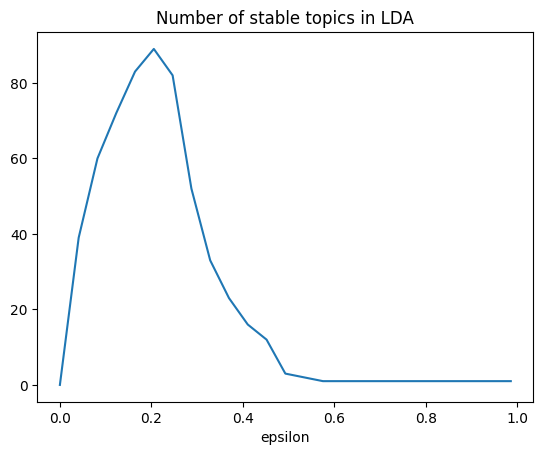

In [45]:
plt.plot(eps, num_topics)
plt.title("Number of stable topics in LDA")
plt.xlabel("epsilon")
plt.show()

eps (float) – epsilon (float, optional) – Defaults to 0.1. Epsilon for the CBDBSCAN clustering that generates the stable topics.

In [37]:
eps = 0.5340039665651672
ensemble.recluster(eps=eps, min_samples=2, min_cores=2)
ensemble.print_topics()

[(0,
  '0.081*"model" + 0.027*"system" + 0.022*"user" + 0.022*"evalu" + 0.021*"studi" + 0.021*"recommend" + 0.019*"intent" + 0.019*"convers" + 0.017*"research" + 0.015*"literatur"'),
 (1,
  '0.043*"process" + 0.031*"analysi" + 0.027*"drift" + 0.024*"review" + 0.024*"concept" + 0.019*"mine" + 0.019*"dt" + 0.017*"ontolog" + 0.016*"research" + 0.014*"exist"')]

## Classify papers according to LDA topic
* Add topic id to each review paper
* Based on abstract
* 2D-Plot by similarity
* Plot by year